In [12]:
import numpy as np
from matplotlib import path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from funcs import calcular_IJ, calcular_streamline

In [13]:
Vinf = 1
num_front = 257  # Numero de fronterasw o vértices

alpha_grad = 0
alpha_rad = alpha_grad * (np.pi / 180)

tO = (360 / (num_front - 1)) / 2

theta = np.linspace(0, 360, num_front)
theta = theta + tO
theta = theta * (np.pi / 180)


XB = np.cos(theta)
YB = np.sin(theta)

num_pan = len(XB) - 1

borde = np.zeros(num_pan)

edge = (XB[1:] - XB[:-1]) * (YB[1:] + YB[:-1])

sum_edge = np.sum(edge)

if sum_edge < 0:
    XB = np.flipud(XB)
    YB = np.flipud(YB)

XC = np.zeros(num_pan)
YC = np.zeros(num_pan)
S = np.zeros(num_pan)
phi = np.zeros(num_pan)

XC = 0.5 * (XB[:-1] + XB[1:])
YC = 0.5 * (YB[:-1] + YB[1:])
dx = XB[1:] - XB[:-1]
dy = YB[1:] - YB[:-1]
S = np.sqrt(dx**2 + dy**2)
phi = np.arctan2(dy, dx)
phi = np.where(phi < 0, phi + 2 * np.pi, phi)

phi = np.arctan2(dy, dx)

phi = np.where(phi < 0, phi + 2 * np.pi, phi)

delta = phi + (np.pi / 2)
beta = delta - alpha_rad
beta[beta > 2 * np.pi] = beta[beta > 2 * np.pi] - 2 * np.pi

In [14]:
I, J = calcular_IJ(XC, YC, XB, YB, phi, S)

A = I + np.pi * np.eye(num_pan, num_pan)
b = -Vinf * 2 * np.pi * np.cos(beta)

lam = np.linalg.solve(A, b)
print("Sum of Lambda: ", round(sum(lam * S), 3))

Sum of Lambda:  0.0


In [15]:
Vt = np.zeros(num_pan)
Cp = np.zeros(num_pan)
for i in range(num_pan):
    addVal = 0
    for j in range(num_pan):
        addVal = addVal + (lam[j] / (2 * np.pi)) * J[i, j]

    Vt[i] = Vinf * np.sin(beta[i]) + addVal
    Cp[i] = 1 - (Vt[i] / Vinf) ** 2

    analyticTheta = np.linspace(0,2*np.pi,200)
analyticCP    = 1 - 4*np.sin(analyticTheta)**2

CN = -Cp*S*np.sin(beta)
CA = -Cp*S*np.cos(beta)

# Compute lift and drag coefficients
CL = sum(CN*np.cos(alpha_rad)) - sum(CA*np.sin(alpha_rad))
CD = sum(CN*np.sin(alpha_rad)) + sum(CA*np.cos(alpha_rad))

print("CL      : ",round(CL, 3))
print("CD      : ",round(CD, 3))

CL      :  -0.0
CD      :  -0.0


# Streamlines

In [16]:
nGridX = 100
nGridY = 100
xVals = [-1.5, 1.5]
yVals = [-1.5, 1.5]

slPct = 30
Ysl = np.linspace(yVals[0], yVals[1], int((slPct / 100) * nGridY))
Xsl = xVals[0] * np.ones(len(Ysl))
XYsl = np.vstack((Xsl.T, Ysl.T)).T

Xgrid = np.linspace(xVals[0], xVals[1], nGridX)
Ygrid = np.linspace(yVals[0], yVals[1], nGridY)
XX, YY = np.meshgrid(Xgrid, Ygrid)

Vx = np.zeros([nGridX, nGridY])
Vy = np.zeros([nGridX, nGridY])

AF = np.vstack((XB.T, YB.T)).T
afPath = path.Path(AF)

for m in range(nGridX):
    for n in range(nGridY):
        XP = XX[m, n]
        YP = YY[m, n]
        Mx, My = calcular_streamline(XP, YP, XB, YB, phi, S)
        if afPath.contains_points([(XP, YP)]):
            Vx[m, n] = 0
            Vy[m, n] = 0
        else:
            Vx[m, n] = Vinf * np.cos(alpha_rad) + sum(lam * Mx / (2 * np.pi))
            Vy[m, n] = Vinf * np.sin(alpha_rad) + sum(lam * My / (2 * np.pi))

Vxy = np.sqrt(Vx**2 + Vy**2)
CpXY = 1 - (Vxy / Vinf)**2


# Tabla de datos

In [17]:
import pandas as pd

data = pd.DataFrame()
data["Ángulo [grados]"] = np.degrees(beta)
data["Lambda"] = lam
data["Velocidad"] = Vt
data["Coeficiente de Presión"] = Cp
data = data.iloc[::-1].reset_index(drop=True)
data["Panel"] = data.index + 1

# Print the rounded data
print(
    round(
        data[
            [
                "Panel",
                "Ángulo [grados]",
                "Lambda",
                "Velocidad",
                "Coeficiente de Presión",
            ]
        ],
        4,
    )
)

print("\n\n")

# Convert the rounded data to CSV and print it
csv_data = round(
    data[
        [
            "Panel",
            "Ángulo [grados]",
            "Lambda",
            "Velocidad",
            "Coeficiente de Presión",
        ]
    ],
    4,
).to_csv(index=False)
print(csv_data)

     Panel  Ángulo [grados]  Lambda  Velocidad  Coeficiente de Presión
0        1           1.4062 -2.0102     0.0491                  0.9976
1        2           2.8125 -2.0084     0.0981                  0.9904
2        3           4.2187 -2.0054     0.1471                  0.9784
3        4           5.6250 -2.0012     0.1960                  0.9616
4        5           7.0313 -1.9957     0.2448                  0.9401
..     ...              ...     ...        ...                     ...
251    252         354.3750 -2.0012    -0.1960                  0.9616
252    253         355.7812 -2.0054    -0.1471                  0.9784
253    254         357.1875 -2.0084    -0.0981                  0.9904
254    255         358.5938 -2.0102    -0.0491                  0.9976
255    256         360.0000 -2.0108    -0.0000                  1.0000

[256 rows x 5 columns]



Panel,Ángulo [grados],Lambda,Velocidad,Coeficiente de Presión
1,1.4062,-2.0102,0.0491,0.9976
2,2.8125,-2.0084,0.0981,0.99

# Gráficas

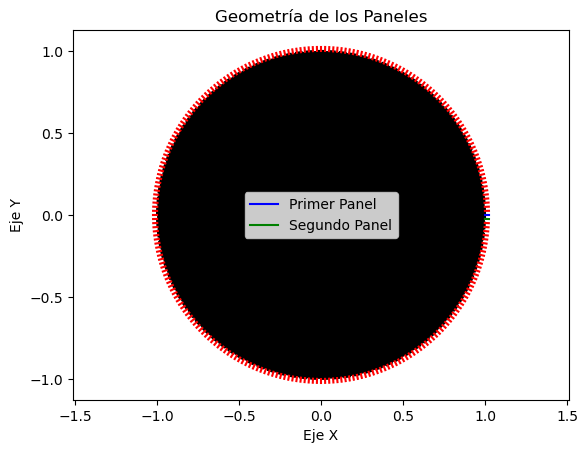

In [18]:
angCirc = np.linspace(0, 2 * np.pi, 1000)
xCirc = np.cos(angCirc)
yCirc = np.sin(angCirc)
fig = plt.figure(1)
plt.cla()
plt.plot(xCirc, yCirc, "k--")
plt.fill(XB, YB, "k")
X = np.zeros(2)
Y = np.zeros(2)
for i in range(num_pan):
    X[0] = XC[i]
    X[1] = XC[i] + S[i] * np.cos(delta[i])
    Y[0] = YC[i]
    Y[1] = YC[i] + S[i] * np.sin(delta[i])
    if i == 0:
        plt.plot(X, Y, "b-", label="Primer Panel")
    elif i == 1:
        plt.plot(X, Y, "g-", label="Segundo Panel")
    else:
        plt.plot(X, Y, "r-")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Geometría de los Paneles")
plt.axis("equal")
plt.legend()
plt.show()

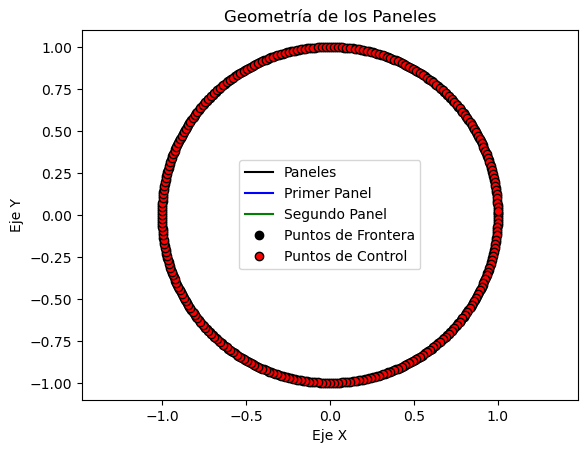

In [19]:
plt.plot(XB, YB, "k-", label="Paneles")
plt.plot([XB[0], XB[1]], [YB[0], YB[1]], "b-", label="Primer Panel")
plt.plot([XB[1], XB[2]], [YB[1], YB[2]], "g-", label="Segundo Panel")
plt.plot(XB, YB, "ko", markerfacecolor="k", label="Puntos de Frontera")
plt.plot(XC, YC, "ko", markerfacecolor="r", label="Puntos de Control")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Geometría de los Paneles")
plt.axis("equal")
plt.legend()
plt.show()

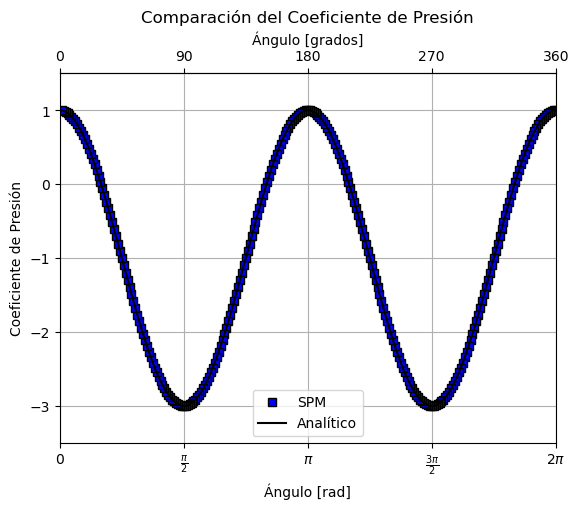

In [20]:
# Graficar el coeficiente de presión del método de paneles
plt.plot(beta, Cp, "ks", markerfacecolor="blue", label="SPM")
# Graficar el coeficiente de presión analítico
plt.plot(analyticTheta, analyticCP, "k", label="Analítico")

# Etiquetas y título
plt.xlabel("Ángulo [rad]")
plt.ylabel("Coeficiente de Presión")
plt.title("Comparación del Coeficiente de Presión")

# Límites de los ejes
plt.xlim(0, 2 * np.pi)
plt.ylim(-3.5, 1.5)

# Etiquetas personalizadas en el eje x
plt.xticks(
    [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi],
    ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
)
# Crear un eje x secundario con los ángulos en grados
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi])
secax.set_xticklabels(["0", "90", "180", "270", "360"])
secax.set_xlabel("Ángulo [grados]")

# Mostrar leyenda y cuadrícula
plt.legend()
plt.grid(True)
plt.show()

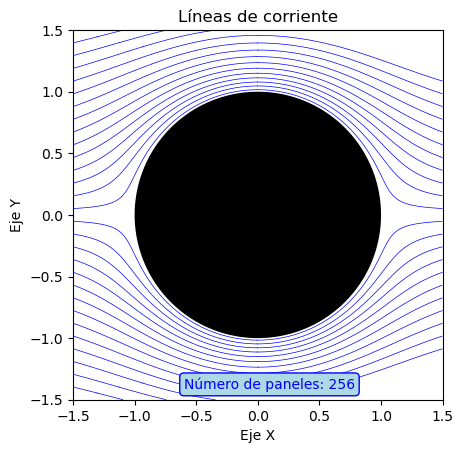

In [21]:
np.seterr(under="ignore")

fig = plt.figure(4)
plt.cla()
plt.streamplot(
    XX,
    YY,
    Vx,
    Vy,
    linewidth=0.5,
    density=10,
    color="b",
    arrowstyle="-",
    start_points=XYsl,
)
plt.fill(XB, YB, "k")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Líneas de corriente")
plt.gca().set_aspect("equal")
plt.xlim(xVals)
plt.ylim(yVals)
plt.annotate(
    f"Número de paneles: {num_pan}",
    xy=(0.3, 0.03),
    xycoords="axes fraction",
    fontsize=10,
    color="blue",
    bbox=dict(
        boxstyle="round,pad=0.3", edgecolor="blue", facecolor="lightblue"
    ),
)

plt.show()

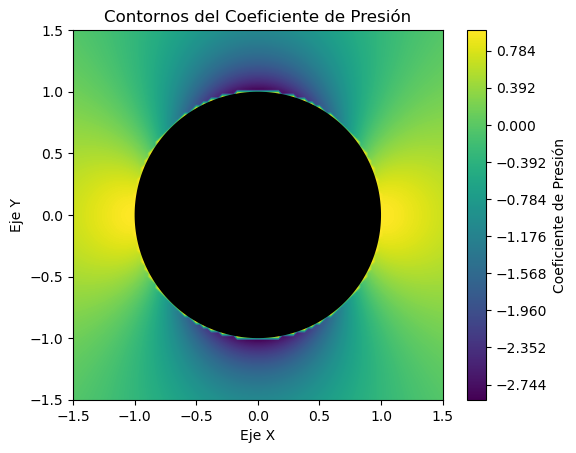

El valor mínimo del coeficiente de presión es: -2.901


In [22]:
min_cp = np.min(CpXY)
norm = mcolors.Normalize(vmin=min_cp, vmax=1)
contour = plt.contourf(XX, YY, CpXY, 500, cmap="viridis", norm=norm)
plt.fill(XB, YB, "k")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Contornos del Coeficiente de Presión")
plt.gca().set_aspect("equal")
plt.xlim(xVals)
plt.ylim(yVals)
cbar = plt.colorbar(contour)
cbar.set_label("Coeficiente de Presión")
plt.show()

print("El valor mínimo del coeficiente de presión es:", round(min_cp, 3))